# PiAE - Projekt 2

 Systemy rozpoznawania twarzy oparte są na założeniu
że każda osoba ma określoną strukturę twarzy, co oznacza, że
wszelkie twarze mają charakterystyczne cechy. Te
charakterystyczne cechy nazywane są eigenfaces, ponieważ
są wektorami własnymi (głównymi składowymi) zbioru
twarzy. Możemy je wydobyć z oryginalnej twarzy za pomocą narzędzia matematycznego o nazwie Principal
Analiza składowa (PCA).

Stosując technikę PCA możemy przekształcić dowolny oryginalny
obraz twarzy z zestawu treningowego do
odpowiedniego eigenface. Rozpoznanie następuje przez
projekcje nowego obrazu nieznanej twarzy do
podprzestrzeni rozpiętej przez powierzchnie własne. Ta podprzestrzeń to
tak zwana „przestrzenią twarzy”. Następnie możemy sklasyfikować twarz
porównując swoją pozycję w przestrzeni twarzy z twarzami
pozycja zestawu treningowego.

Zakładamy, że każdy obraz twarzy $I(x,y)$ składa się z $N$
piksele. Możemy więc przedstawić dowolny obraz jako tablicę
$N \times N$ . Możemy również uznać, że obrazem twarzy jest
wektor (lub punkt) wymiaru $N^2$

Zbiór danych ma którym będziemy pracować:

In [1]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape
import numpy as np

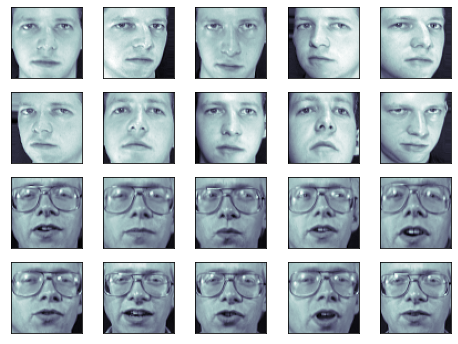

In [2]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

### Podział na zbiór trenignowy i testowy

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.images,
        faces.target, random_state=0)

print(X_train.shape, X_test.shape)

(300, 64, 64) (100, 64, 64)


### 1.Obliczanie twarzy własnych za pomocą PCA

Przygotuj dane.
Przygotuj zestaw treningowy obrazów twarzy $i_1, i_2 … , i_M$
do przetwarzania. Obrazy twarzy muszą być wyśrodkowane,
w skali szarości i w tym samym rozmiarze (w przypadku naszych zdjęć już tak jest). Zestaw treningowy
powinien zawierać kilka obrazów dla każdej osoby, z pewnymi różnicami w twarzy i w
oświetleniu. Przykładowy zestaw treningowy pokazano wyżej

### 2.Oblicz średnią twarz
Średnia twarz zbioru treningowego jest określona przez:
$$sr = \frac{1}{M}\sum_{n=1}^{M}i_n$$
Każda twarz różni się od średniej wektorem:
$$f_k = i_k -sr , k =1, \dots, M$$

$i_n$ to konkretny obraz natomiast $f_k$ to obraz z różnicą średniej
W naszym przypadku wartość $M = 300$ ponieważ mamy 300 zdjęć treningowych i 100 testowych.
Po obliczeniu średniej twarzy i wyświetleniu powinien się nam ukazać taki obraz
<img src="files/srednia.png">

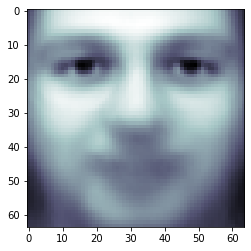

In [4]:
suma = sum(X_train)
sr = suma / 300

plt.imshow(sr, cmap=plt.cm.bone)
plt.show()

### 3. Obliczenie macierzy kowariancji
Na początek musimy stworzyć tablice z naszymi obrazami różnicy średniej. Czyli zbiór $$A = [f_1, f_2, ... , f_k]$$
Obrazy różnicy średniej powinny być spłaszone do wektora o rozmiarze 1 x 64 * 64 ponieważ taki jest rozmiar obrazu.
Macierz kowariancji obliczzamy ze wzoru:
$$ C' = A^T*A$$
Niestety ta macierz jest bardzo duża i mielibyśmy bardzo kosztowne obliczeniowo zadanie na 4096 wektorów i wartości własnych. Dlatego skorzystamy z pewnego triku i nie wdając sie w zbędne szczegóły matematyczne naszą macierzą kowariancji będzie 
$$ C =A*A^T $$ , która jest rozmiaru 400x400 a nie 4096*4096
Dzięki temu zabiegowi możemy uzyskać wartości własne macierzy $C'$ jako $u_i = A^T*v_i$ gdzie $v_i$ to i-ty wektor własny macierzy $C$.
$u_i$ jest nazywane twarzą własną

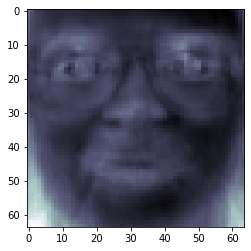

In [5]:
A = []
for i in range(300):
    A.append((X_train[i]-sr).flatten())
    
A = np.array(A)
C = A.dot(A.T)

eigenValues, eigenVectors = np.linalg.eig(C)
u = A.T.dot(eigenVectors)

plt.imshow(u.T[0].reshape(64,64), cmap=plt.cm.bone)
plt.show()

Kiedy mamy już wyznaczone twarze własne u możemy wyświetlić przykładową. Na początek musimy transponować tą macierz twarzy własnych a następnie zmienić rozmiar takiej twarzy na 64x64 ponieważ twarz własne jest przedstawiona jako wektor o 64 * 64 elementach. Przykładowa pierwsza twarz własna:
<img src="files/face.png">

### Rekonstrukcja twarzy różnicy średniej 
Musimy pamiętać o znormalizowaniu wektorów. Zanim przystąpimy do dalszej pracy spróbujmy znormlizować nasze twarze własne.
Aby to zrobić musimy każdą jego składową podzielić przez jego długość. Wtedy otrzymamy wektor o długośći 1. Bierzemy naszą macierz u transponowaną i dzielimy przez długość takiego wektora. Poszłuży nam za to funkcja np.linalg.norm(u.T[i])), która wyznacza długość wektora podanego jako argument. 

In [6]:
#znormalizowanie wektorów
for i in range(300):
    u.T[i] = (u.T[i]/np.linalg.norm(u.T[i]))

Text(0.5, 1.0, 'oryginał')

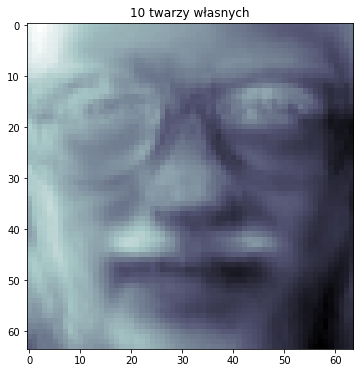

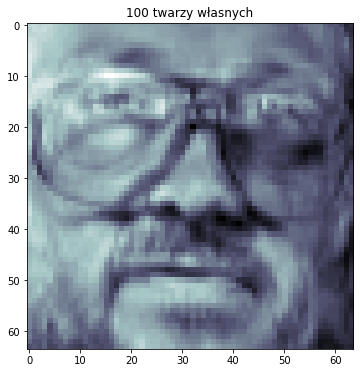

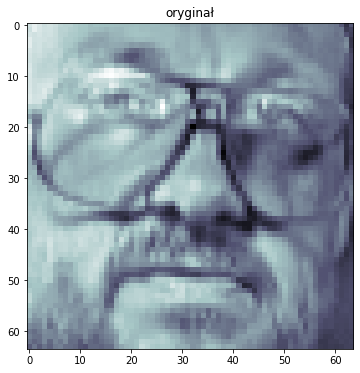

In [7]:
#wzynaczenie wspólczynnikóœ dla różnych średnich
exampleData = A[100]    

a10 = u.T[0].dot(exampleData)*u.T[0]
for i in range(1,10):
    a10 += u.T[i].dot(exampleData)*u.T[i]
 
fig = plt.figure(figsize=(8,6))
plt.imshow(a10.reshape(64,64), cmap=plt.cm.bone)
plt.title("10 twarzy własnych")

####################################################################
a100 = u.T[0].dot(exampleData)*u.T[0]
for i in range(1,100):
    a100 += u.T[i].dot(exampleData)*u.T[i]
 
fig = plt.figure(figsize=(8,6))
plt.imshow(a100.reshape(64,64), cmap=plt.cm.bone)
plt.title("100 twarzy własnych")

####################################################################
fig = plt.figure(figsize=(8,6))
plt.imshow(exampleData.reshape(64,64), cmap=plt.cm.bone)
plt.title("oryginał")

Kolejnym etapem projektu będzie wyznacznenie odpowednich współczynników dla naszych twarzy różnicy średnich.
$$f_i = \sum_{j=1}^{k} w_j*u^T_j $$ 
gdzie $w_j = u^T_j*f_i$
Jest to rekonstrukcja twarzy różnicy średniej za pomocą wszystkich tearzy własnych pomnożonych przez współrzędne $w_j$
Wartość k oznacza liczbę twarzy własnych, które będziemy wykorzystywać do reknostrukcji k<=M=300. To zadanie spróbójmy wykonać dla zdjęcia o indeksie 100.
Przykładowa rekonstrucja twarzy średniej dla k = 100 i k= 300 wraz z porównaniem do oryginału:
<img src="files/face_oryg.png">
Oryginał
<img src="files/face_300.png">
300 twarzy własnych
<img src="files/face100.png">
100 twarzy własnych

### Wpisanie współczynników w do rekonstrukcji zdjęć
Kolejnym etapem jest wyznaczenie dla każdego zdjęcia treningowego współczynników w
$w_j = u^T_j*f_i$
Czyli każdą twarz własną mnożymy z każdym obrazem różnicy średniej dzieki czemu powstanie nam k współczynników dla każdego zdjęcia 

In [8]:
wsp = []
for i in range(300):
    tab = []
    for j in range(300):
        tab.append(u.T[j].dot(A[i]))
    tab = np.array(tab)
    wsp.append(tab)
wsp = np.array(wsp)
wsp.shape

(300, 300)

### Próba klasyfikacji
Ostatnim etapem będzie próba klasyfikacji
Na początek z obrazu testowego tworzymy obraz różnicy średniej poprzez odjęcie od oryginału wyznaczony wcześniej obraz średni. Kolejnym etapem jest wyznaczenie współczynników $w_j$ dla tego obrazu tak samo jak w przypadku zbioru treningowego. Ostatnim etapem będzie porównanie obrazu ze zbiorem treningowym i odpowiednia klasyfikacja. Robimy to w ten sposób:
$$a_{test} = [w_1, w_2, ... , w_k], a_{train} = [w_1^i, w_2^i, ..., w_k^i]$$
Następnie liczymy $g = min_i||a_{test}-a_{train}||_2$
Dla tego i, dla którego mamy najmniejszą wartość g, przypisujemy obraz treningowy i przypisujemy mu klasę obrazu treningowego o indeksie i.
Sprawdzamy to dla każdego obrazu testowego i wyznaczamy skuteczność takiej klasyfikacji. Powinna być około 95%.

In [9]:
A_train = []
for i in range(300):
    A_train.append((X_train[i]-sr).flatten())
A_train = np.array(A_train)
print("A_train.shape =",A_train.shape)

C = A_train.dot(A_train.T)
eigenValues, eigenVectors = np.linalg.eig(C)
u = A_train.T.dot(eigenVectors)
print("u_train.shape =",u.shape)

#znormalizowanie wektorów
for i in range(300):
    u.T[i] = (u.T[i]/np.linalg.norm(u.T[i]))

wsp_train = []
for i in range(300):
    tab = []
    for j in range(300):
        tab.append(u.T[j].dot(A[i]))
    tab = np.array(tab)
    wsp_train.append(tab)
wsp_train = np.array(wsp_train)
print("wsp_train.shape =",wsp_train.shape)

A_train.shape = (300, 4096)
u_train.shape = (4096, 300)
wsp_train.shape = (300, 300)


In [10]:
A_test = []

for i in range(100):
    A_test.append((X_test[i]-sr).flatten())
A_test = np.array(A_test)
A_test.shape
print("A_test.shape =",A_test.shape)

wsp_test = []
for i in range(100):
    tab = []
    for j in range(300):
        tab.append(u.T[j].dot(A_test[i]))
    tab = np.array(tab)
    wsp_test.append(tab)
wsp_test = np.array(wsp_test)
print("wsp_test.shape =",wsp_test.shape)

A_test.shape = (100, 4096)
wsp_test.shape = (100, 300)


In [12]:
score = 0
for i in range(100):
    dlu_i = ((wsp_train[0]-wsp_test[i])**2).sum()
    klasa = 0
    for j in range(1, 300):
        dlu_j = ((wsp_train[j]-wsp_test[i])**2).sum()
        if  dlu_i > dlu_j:
            dlu_i = dlu_j
            klasa = j
    score += (y_test[i] == y_train[klasa])
    
print("Skteczonść klasyfikacji =",score)

Sktecznść klasyfikcji = 95
